Load And Split Datasets

In [ ]:
import pandas as pd

# Load and Split Train Datasets

train = pd.read_csv('train.csv', delimiter=";")

X_train = train['title'].values + train['text'].values
Y_train = train['label'].values

# Load and Split Test Datasets

test = pd.read_csv('test.csv', delimiter=";")

X_test = test['title'].values + test['text'].values
Y_test = test['label'].values

# Load and Split Evaluations Datasets

eval = pd.read_csv('evaluation.csv', delimiter=";")

X_eval = eval['title'].values + eval['text'].values
Y_eval = eval['label'].values


Preprocessing Data

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenizer Data

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Tokenizer Data to Sequences

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
eval_sequences = tokenizer.texts_to_sequences(X_eval)

# Padding Sequences to Max Length

max_length = 300

pad_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
pad_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
pad_eval_sequences = pad_sequences(eval_sequences, maxlen=max_length, padding='post', truncating='post')

Preprocessing Real and Fake Data

In [ ]:
real_pad_train = pad_train_sequences[Y_train == 0]
fake_pad_train = pad_train_sequences[Y_train == 1]

real_pad_test = pad_test_sequences[Y_test == 0]
fake_pad_test = pad_test_sequences[Y_test == 1]

real_pad_eval = pad_eval_sequences[Y_eval == 0]
fake_pad_eval = pad_eval_sequences[Y_eval == 1]


Parameters

In [ ]:
Latent_dim = 150
Batch_size = 128
epochs = 5000

Generator And Discriminator

In [59]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

# Build Generator

G = Sequential([
    Dense(128, activation="relu", input_dim = Latent_dim),
    Dense(256, activation="relu"),
    Dense(max_length, activation="sigmoid")
])

# Build Dicriminator

D = Sequential([
    Dense(256, activation="relu", input_dim=max_length),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

GAN

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten, Input
from keras.models import Model
from keras.optimizers import Adam
import numpy as np

# Build GAN

D.trainable = False
gan_input = Input(shape = (G.input_shape[1],))
fake_output = G(gan_input)
gan_output = D(fake_output)
gan = Model(gan_input, gan_output)
gan.compile(optimizer = Adam(learning_rate = 0.0002), loss='binary_crossentropy')

# Real Data and Fake Data for Train, Validation

real_data = real_pad_train
fake_data = fake_pad_train

real_val = real_pad_test
fake_val = fake_pad_test

# Discriminator History

train_D_loss = []
train_D_accuracy = []
val_D_loss = []
val_D_accurary = []

# Generator History

train_G_loss = []

# Early Stopping

best_val_acc = 0
patience = 10
patience_counter = 0

# Train GAN

half_batch = Batch_size // 2

for epoch in range(epochs):

    # Train Discriminator with Real Data:

    real_idx = np.random.randint(0, real_data.shape[0], half_batch)
    real_samples = real_data[real_idx]
    y_real = np.zeros((half_batch, 1))

    # Generate Fake Samples:

    noise = np.random.normal(0, 1, (half_batch, Latent_dim))
    fake_samples = G.predict(noise)
    y_fake = np.ones((half_batch, 1))

    # Combine Real and Fake samples for Training Discriminator

    X_D = np.vstack([real_samples, fake_samples])
    Y_D = np.vstack([y_real, y_fake])

    # Shuffle the Combined Data

    idx = np.random.permutation(X_D.shape[0])
    X_D = X_D[idx]
    Y_D = Y_D[idx]

    # Train Discriminator

    D.trainable = True
    D.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    D_Loss = D.train_on_batch(X_D, Y_D)

    # Train Generator

    noise = np.random.normal(0, 1, (Batch_size, Latent_dim))
    y_valid = np.zeros((Batch_size, 1))
    G_Loss = gan.train_on_batch(noise, y_valid)

    # Validation Data

    if epoch % 10 == 0:

        # Get Real Validation Set

        val_real_idx = np.random.randint(0, real_val.shape[0], half_batch)
        val_real_samples = real_val[val_real_idx]
        val_real_y = np.zeros((half_batch, 1))

        # Create Fake Samples for Validation

        val_noise = np.random.normal(0, 1, (half_batch, Latent_dim))
        val_fake_samples = G.predict(val_noise)
        val_fake_y = np.ones((half_batch, 1))

        # Evaluate on Validation Set

        val_X = np.vstack([val_real_samples, val_fake_samples])
        val_Y = np.vstack([val_real_y, val_fake_y])

        # Shuffle Validation Data

        val_idx = np.random.permutation(val_X.shape[0])
        val_X = val_X[val_idx]
        val_Y = val_Y[val_idx]

        # Validation Loss

        D_Loss_Val = D.evaluate(val_X, val_Y, verbose = 0)

        # Save Validation Metrics

        val_D_loss.append(D_Loss_Val[0])
        val_D_accurary.append(D_Loss_Val[1])

        # Early Stopping based on Validation accuracy

        if D_Loss_Val[1] > best_val_acc:
            best_val_acc = D_Loss_Val[1]
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early Stopping at Epoch: {epoch}")
            G.save("Generator.h5")
            D.save("Discriminator.h5")
            break


        # Save Training Metrics

    train_D_loss.append(D_Loss[0])
    train_D_accuracy.append(D_Loss[1])
    train_G_loss.append(G_Loss)

    if epoch % 100 == 0:
       print(f"Epoch {epoch + 1} / {epoch} [D loss: {D_Loss[0]:.4f}, acc: {D_Loss[1]:.4f}] [G Loss: {G_Loss:.4f}]")



In [65]:
from keras.models import load_model

generator = load_model("Generator.h5")
discriminator = load_model("Discriminator.h5")

generator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

noise_eval = np.random.normal(0, 1, (pad_eval_sequences.shape[0], Latent_dim))

eval_fake_samples = generator.predict(noise_eval)

eval_real_D_loss = discriminator.evaluate(pad_eval_sequences, np.zeros(pad_eval_sequences.shape[0], 1), verbose = 0)
eval_fake_D_loss = discriminator.evaluate(eval_fake_samples, np.ones(pad_eval_sequences.shape[0], 1), verbose = 0)

print("Evaluation Result: ")
print(f"Discriminator Loss on Real Data: {eval_real_D_loss:.4f}")
print(f"Discriminator Loss on Fake Data: {eval_fake_D_loss:.4f}")



254/254 [==============================] - 1s 3ms/step


TypeError: Cannot interpret '1' as a data type

Show and Save Plot Models Train

ValueError: x and y must have same first dimension, but have shapes (10,) and (91,)

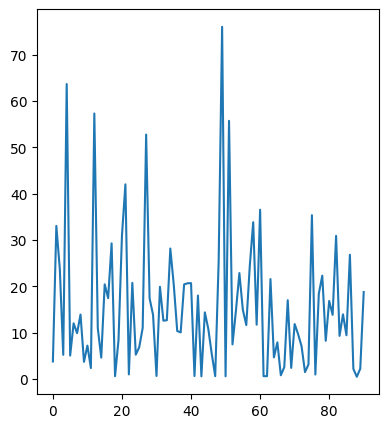

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot Discriminator Loss

plt.subplot(1, 3, 1)
plt.plot(train_D_loss, label = "Train")
plt.plot(
    np.arange(0, len(train_D_loss), 10),
    train_D_loss,
    label = "Validation"
)
plt.title("Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Discriminator Accuracy

plt.subplot(1, 3 ,2)
plt.plot(train_D_accuracy, label = "Train")
plt.plot(
    np.arange(0, len(train_D_accuracy), 10),
    train_D_accuracy,
    label = "Validation"
)
plt.title("Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Generator Loss

plt.subplot(1, 3 ,3)
plt.plot(train_G_loss)
plt.title("Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

# plt.savefig("plot.png")

plt.show()

Show and Save Evaluate Models

In [ ]:
real_eval = real_pad_eval
real_eval_y = Y_eval['label' == 0]

# Evaluate Discriminator

real_loss, real_acc = D.evaluate(X_eval, Y_eval, verbose = 0)

# Evaluate Generator

noise = np.random.normal(0, 1, (len(real_eval), Latent_dim))
eval_fake_samples = G.predict(noise)
eval_fake_y = np.ones(len(eval_fake_samples), 1)
fake_loss, fake_acc = D.evaluate(eval_fake_samples, eval_fake_y, verbose = 0)

# Plot Evaluate Models

fig = plt.figure(figsize=(20, 15))

# Accuracy Plot

plt.subplot(2, 2, 1)
accuracies = [real_acc, fake_acc]
plt.bar(['Real News', 'Generated News'], accuracies)
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')

for i,v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha = 'center')
plt.ylim(0, 1.1)

# Loss Plot

plt.subplot(2, 2, 2)
losses = [real_loss, fake_loss]
plt.bar(['Real News', 'Generated News'], losses)
plt.title('Classification Loss')
plt.ylabel('Loss')
for i,v in enumerate(losses):
    plt.text(i, v + 0.01, f'{v:.3f}', ha = 'center')

# Show Plot

plt.tight_layout()
plt.show()

# Save Plot

plt.savefig('evaluate.png')

Save Models

In [ ]:
import pickle

G.save('Generator.h5')
D.save('Discriminator.h5')
gan.save('GAN.h5')
with open('tokenizer_GAN.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)